# Example 7: Rotational barrier prediction in KRAS inhibitors

## Objective
The objective of this task is to use the `molli` workflow to transition from `.CDXML` molecular drawings to full-fledged 3D structures with subsequent CREST//GFN2-XTB conformer generation, ORCA equilibrium structure minimization, as well as ORCA relaxed surface scan.
This workflow is useful to assess semi-quantitatively the possibility of hindered rotation in a number of molecules (see e. g. [*J. Med. Chem.* **2020**, *63*, 1, 52](https://doi.org/10.1021/acs.jmedchem.9b01180))

## Prerequisites
- `molli` installation
- `pandas` installation (it is NOT a dependency of molli and must be installed separately)
- `OpenBabel` installation (it is NOT a dependency of molli and must be installed separately)
    Note: if you experience problems with openbabel refusing to optimize the structures, do not forget to set the `BABEL_DATADIR` environment variable to point to a valid location with openbabel data files. With conda installations, it seems to be consistently pointing to `$CONDA_PREFIX/share/openbabel`
- `barriers.csv` file that has the experimental rotational barriers listed
- `cladosporin.cdxml` file that contains the structural drawings

## Methods

### Conformer generation
Rotational barrier profiles are generated using b97-3c method, as reported by Grimme et al.

In [1]:
import molli as ml
from molli.external import openbabel
from math import degrees

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# This configures on-screen preview of molecules
ml.visual.configure(bgcolor="black", theme="dark", width=500)

## Step 1. `CDXML` Parsing

In this step, all of the molecules are read from the CDXML file and converted into their 3D versions.
This can be done from both the command line interface, but for the sake of exercise, this workflow will show the script that utilizes the key function of `ml.Molecule.join(...)`

To make sure that the parsing step was successful, we will perform a basic inspection of the resulting `.mlib` file

In [2]:
cdxf = ml.CDXMLFile("rot_barrier.cdxml")
core = cdxf["core"]
core_ap = core.get_attachment_points()[0]
names = set(cdxf.keys())
names.remove("core")
core.add_implicit_hydrogens()

# This is the destination 
lib = ml.MoleculeLibrary("kras_inhibitors.mlib", overwrite=True, readonly=False)

with lib.writing():
    for n in names:
        sub = cdxf[n]
        sub_ap = sub.get_attachment_points()[0]
        
        mol = ml.Molecule.join(
            core,
            sub,
            core_ap,
            sub_ap,
            name=n,
        )

        mol.add_implicit_hydrogens()

        openbabel.obabel_optimize(
            mol,
            ff="MMFF94",
            coord_displace=0.01,
            inplace=True,
        )

        # just a little extra: calculate the preliminary dihedral angle)
        d = mol.dihedral("1", "2", "3", "4")
        print(f"Dihedral {degrees(d):0.2f} for {mol}")

        lib[n] = mol

Dihedral 117.02 for Molecule(name='23', formula='C28 H29 Cl1 F1 N5 O2')
Dihedral 113.62 for Molecule(name='25', formula='C27 H27 Cl1 F1 N5 O2')
Dihedral 134.54 for Molecule(name='28', formula='C24 H24 Cl1 F1 N6 O2 S1')
Dihedral 144.75 for Molecule(name='27', formula='C24 H25 Cl1 F1 N7 O2')
Dihedral 131.87 for Molecule(name='18', formula='C27 H27 Cl1 F1 N5 O2')
Dihedral 128.08 for Molecule(name='29', formula='C25 H27 Cl1 F1 N7 O2')
Dihedral 111.87 for Molecule(name='24', formula='C28 H29 Cl1 F1 N5 O2')
Dihedral 139.62 for Molecule(name='26', formula='C26 H26 Cl1 F1 N6 O2')
Dihedral 126.61 for Molecule(name='22', formula='C27 H25 Cl1 F1 N5 O2')


In [3]:
%mlib_view kras_inhibitors.mlib 22

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

We will now import the molecule library into our python code. the success of this step will be demonstrated by rendering the parsing result of an arbitrary molecule. Give it a try and substitute the name with any names that were obtained in the inspect stage!

## Step 2. XTB relaxed surface scan.

In this step we will be attempting to generate the guess structure of the transition state of the hindered rotation by performing the *Relaxed Surface Scan* of the rotation.

In [4]:
# Jupyter does not play nice with the Thread parallelism, so we placed the workflow in a separate file.
!python scan.py 

Submitting jobs: 0it [00:00, ?it/s]
Waiting for jobs: 0it [00:00, ?it/s]
Finalizing the calculations: 100%|███████████████| 9/9 [00:00<00:00, 180.65it/s]


9 2 43 44 70.75379386832473
Minima: [], maxima: [26] 255.47593799748057


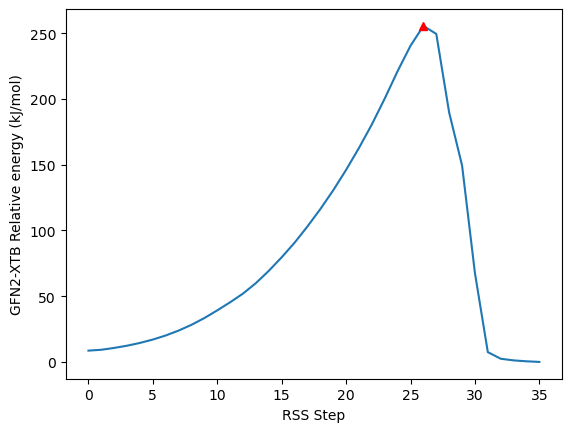

In [5]:
scan_lib = ml.ConformerLibrary("kras_inhibitors_scan.clib")

with scan_lib.reading():
    ens = scan_lib["25"]

# nrg = [
#     x["ORCA/SCF_Energy"] + x["ORCA/VdW_Correction"]
#     for x in ens.attrib["conformer_attrib"]
# ]

nrg = ens.attrib['XTB/Conformer_Energies']

nrg_rel = 2625.5 * (nrg - np.min(nrg))

idx = ens.get_atom_indices("2", "1", "3", "4")
print(*idx, np.degrees(ens[28].dihedral(*idx)))

minima, _ = find_peaks(-nrg_rel, distance=10)
maxima, _ = find_peaks(nrg_rel, distance=10, height=10)

plt.plot(nrg_rel)
plt.plot(minima, nrg_rel[minima], "ob")
plt.plot(maxima, nrg_rel[maxima], "^r")
plt.xlabel("RSS Step")
plt.ylabel("GFN2-XTB Relative energy (kJ/mol)")
print(f"Minima: {minima}, maxima: {maxima}", np.max(nrg_rel[maxima]))

In [6]:
with scan_lib.reading():
    for k in sorted(scan_lib.keys()):
        ens = scan_lib[k]
        # nrg = [
        #     x["ORCA/SCF_Energy"] + x["ORCA/VdW_Correction"]
        #     for x in ens.attrib["conformer_attrib"]
        # ]
        
        nrg = ens.attrib['XTB/Conformer_Energies']
        nrg_rel = 2625.5 * (nrg - np.min(nrg))

        eq = 0
        ts_min = np.max(nrg_rel)
        barrier = ts_min - nrg_rel[eq]
        print(f"Approx. barrier {ens.name}: {barrier:6.1f} kJ/mol {barrier/4.184:6.1f} kcal/mol")

Approx. barrier 18:  125.8 kJ/mol   30.1 kcal/mol
Approx. barrier 22:  127.5 kJ/mol   30.5 kcal/mol
Approx. barrier 23:  162.3 kJ/mol   38.8 kcal/mol
Approx. barrier 24:  203.4 kJ/mol   48.6 kcal/mol
Approx. barrier 25:  246.9 kJ/mol   59.0 kcal/mol
Approx. barrier 26:   81.1 kJ/mol   19.4 kcal/mol
Approx. barrier 27:   57.9 kJ/mol   13.8 kcal/mol
Approx. barrier 28:   38.1 kJ/mol    9.1 kcal/mol
Approx. barrier 29:   69.3 kJ/mol   16.6 kcal/mol


Now that we have the approximate structures, we will write out equilibrium structure guesses in one library (`rb_eq_g0.mlib`), and our transition state structures --- into a separate one (`ts_eq_g0.mlib`)

In [7]:
eq_lib = ml.MoleculeLibrary("rb_eq_g0.mlib", readonly=False)
ts_lib = ml.MoleculeLibrary("rb_ts_g0.mlib", readonly=False)

with scan_lib.reading(), eq_lib.writing(), ts_lib.writing():
    for key, ens in scan_lib.items():
        nrg = ens.attrib['XTB/Conformer_Energies']
        nrg_rel = 2625.5 * (nrg - np.min(nrg))

        eq1 = int(np.argmin(nrg_rel[:6]))
        eq2 = int(np.argmin(nrg_rel[-6:]) + len(nrg_rel) - 6)
        ts = int(np.argmax(nrg_rel))

        eq_lib[key + "_eq1"] = ens[eq1]
        eq_lib[key + "_eq2"] = ens[eq2]

        ts_lib[key] = ens[ts]

In [8]:
# This will show both
%mlib_view rb_eq_g0.mlib 26_eq1
%mlib_view rb_ts_g0.mlib 26

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now we need to perform geometry optimizations with ORCA. For transition states we will be using the eigenvector following.

In [9]:
!python rb_w1_opt.py

Optimizing the equilibrium structures
Submitting jobs: 0it [00:00, ?it/s]
Waiting for jobs: 0it [00:00, ?it/s]
Finalizing the calculations: 100%|██████████████| 18/18 [00:00<00:00, 37.60it/s]
Optimizing the transition structures
Submitting jobs: 0it [00:00, ?it/s]
Waiting for jobs: 0it [00:00, ?it/s]
Finalizing the calculations: 100%|████████████████| 9/9 [00:00<00:00, 12.20it/s]


## Step 3: Extracting preliminary barrier and TS geometry
This is the final step in which we will analyze the obtained outputs

In [10]:
# We will analyze the tra
import pandas as pd

ts_lib = ml.MoleculeLibrary("rb_ts_g1.mlib")
eq_lib = ml.MoleculeLibrary("rb_eq_g1.mlib")

with ts_lib.reading(), eq_lib.reading():
    for key in ts_lib.keys():
        if key == "22":
            continue
        ts = ts_lib[key]
        freq = ts.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Vibrational frequencies"]
        
        G_ts = ts.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Gibbs Energy (Hartree)"]
        G_eq1 = eq_lib[key + "_eq1"].attrib["ORCA/THERMOCHEMISTRY_Energies"]["Gibbs Energy (Hartree)"]
        G_eq2 = eq_lib[key + "_eq2"].attrib["ORCA/THERMOCHEMISTRY_Energies"]["Gibbs Energy (Hartree)"]

        dG_act1 = 2625.5*(G_ts - G_eq1)
        dG_act2 = 2625.5*(G_ts - G_eq2) 
        print(f"Barrier for {key}: {dG_act1/4.184:5.1f}, {dG_act2/4.184:5.1f}, {freq[6]=:5.2f}")
    
    ts = ts_lib["26"]

ts

Barrier for 23:   3.7,   4.0, freq[6]=-74.12
Barrier for 25:  34.9,  35.5, freq[6]=-39.53
Barrier for 28:  16.7,  16.5, freq[6]=-33.68
Barrier for 27:  17.2,  17.7, freq[6]=-35.69
Barrier for 18:  25.9,  25.5, freq[6]=-33.52
Barrier for 29:  24.5,  25.1, freq[6]=-30.06
Barrier for 24:  47.6,  48.1, freq[6]=-24.92
Barrier for 26:  22.1,  21.4, freq[6]=-27.45


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Molecule(name='26', formula='C26 H26 Cl1 F1 N6 O2')

## Step 4. Replace the substituents on the transition state

In the previous step we were able to identify a problem: some of the transition states did not converge to what we needed. This can happen, especially considering that XTB geometries can substantially differ from the DFT ones. In order to fix this problem we will use molli's ability to manipulate structures in a streamlined fashion. 

First, we will remove the substituent from atom "2" in the direction of atom "3" (and write the corresponding file)

In [11]:
ts.remove_substituent("2", "3", ap_label="ap1")
with open("ts_core.mol2", "wt") as f:
    ts.dump_mol2(f)

In [12]:
# Create new library
from math import radians
new_ts_lib = ml.MoleculeLibrary("rb_ts_g2.mlib", readonly=False, overwrite=True)
with ts_lib.reading(), new_ts_lib.writing():
    for k, m in ts_lib.items():
        m.remove_substituent("3", "2", ap_label="ap2")
        fused = ml.Molecule.join(ts, m, "ap1", "ap2", optimize_rotation=False,)
        fused.rotate_dihedral(("1", "2", "3", "4"), radians(180))
        fused.name = k
        new_ts_lib[k] = fused


##

In [13]:
!python rb_w2_opt.py

Optimizing the transition structures
Submitting jobs: 0it [00:00, ?it/s]
Waiting for jobs: 0it [00:00, ?it/s]
Finalizing the calculations: 100%|████████████████| 9/9 [00:00<00:00, 16.42it/s]


In [14]:
# In this line one can make sure that all of the transition states look solid now!
%mlib_view rb_eq_g1.mlib 23_eq1

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Step 5. Compile the data in a presentable form.

In [15]:
ts_lib = ml.MoleculeLibrary("rb_ts_g3.mlib")
eq_lib = ml.MoleculeLibrary("rb_eq_g1.mlib")

with ts_lib.reading(), eq_lib.reading():
    data = {}
    for key in sorted(ts_lib.keys()):
        ts = ts_lib[key]
        ts_freq = ts.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Vibrational frequencies"]
        G_ts = ts.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Gibbs Energy (Hartree)"]

        eq1 = eq_lib[key + "_eq1"]
        G_eq1 = eq1.attrib["ORCA/THERMOCHEMISTRY_Energies"][
            "Gibbs Energy (Hartree)"
        ]
        eq1_freq = eq1.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Vibrational frequencies"]

        eq2 = eq_lib[key + "_eq2"]
        G_eq2 = eq2.attrib["ORCA/THERMOCHEMISTRY_Energies"][
            "Gibbs Energy (Hartree)"
        ]
        eq2_freq = eq2.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Vibrational frequencies"]

        dG_act1 = 2625.5 * (G_ts - G_eq1) # This is the (R) -> TS barrier
        dG_act2 = 2625.5 * (G_ts - G_eq2) # This is the (S) -> TS barrier

        nim_eq1 =  np.count_nonzero(eq1_freq < 0)
        nim_eq2 =  np.count_nonzero(eq2_freq < 0)
        nim_ts =  np.count_nonzero(ts_freq < 0)

        data[key] = {
            # "barrier (expt)": 
            "barrier (R->TS)": dG_act1, 
            "barrier (S->TS)": dG_act2,
            "TS low freq": ts_freq[6],
            "TS N imag freq": nim_ts,
            "EQ1 N imag freq": nim_eq1,
            "EQ2 N imag freq": nim_eq2 
        }
        # f"{key}: Barrier={dG_act1:5.1f} ({dG_act2:5.1f}) kJ/mol, TS low freq: {ts_freq[6]:5.2f}, TS #im freq: {nim_ts}, EQ1 #im freq: {nim_eq1}, EQ2 #im freq: {nim_eq2}"

    ts = ts_lib["26"]

pd.DataFrame.from_dict(data=data, orient="index").round(1)

,barrier (R->TS),barrier (S->TS),TS low freq,TS N imag freq,EQ1 N imag freq,EQ2 N imag freq
18,108.3,106.7,-32.2,1,0,0
22,103.2,102.6,-36.5,1,0,0
23,132.0,133.3,-48.3,1,1,0
24,150.0,151.9,-30.0,1,0,0
25,146.1,148.4,-35.0,1,0,0
26,92.6,89.4,-27.8,1,0,0
27,73.7,76.0,-38.6,1,0,0
28,69.9,69.2,-35.0,1,0,0
29,101.3,103.8,-25.5,1,0,0


## Step 6. Resolving the imaginary frequency problem

As can be seen from the table above, the project is nearly complete now. The only remaining problem is that for compound **23** we have accidentally converged to the transition state (as indicated by a single imaginary frequency). Upon closer inspection one can notice that this is the tert-butyl rotation. Here we have a couple of options for dealing with this, but we are going to use the similar approach as before: we will create a new collection and we will repeat the calculation.

In [16]:
with eq_lib.reading():
    mol_fail = eq_lib["23_eq1"]

# This will rotate the tert-butyl into the correct orientation.
mol_fail.rotate_dihedral((50,49,44,43), 0)

mol_fail

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Molecule(name='23', formula='C28 H29 Cl1 F1 N5 O2')

In [17]:
eq_fix = ml.MoleculeLibrary("rb_eq_fix.mlib", readonly=False, overwrite=True)
with eq_fix.writing():
    eq_fix["23_eq1"] = mol_fail

In [18]:
!python rb_w3_opt.py

Optimizing the equilibrium structures (again)
Submitting jobs: 0it [00:00, ?it/s]
Waiting for jobs: 0it [00:00, ?it/s]
Finalizing the calculations: 100%|████████████████| 1/1 [00:00<00:00, 36.99it/s]


Now that the final optimization is done, we will reassemble the library.

In [19]:
eq_fix_g1 = ml.MoleculeLibrary("rb_eq_fix_g1.mlib")
rb_eq_g1 = ml.MoleculeLibrary("rb_eq_g1.mlib")
rb_eq_g2 = ml.MoleculeLibrary("rb_eq_g2.mlib", readonly=False, overwrite=True)

with eq_fix_g1.reading(), rb_eq_g1.reading(), rb_eq_g2.writing():
    for k in rb_eq_g1.keys():
        if k in eq_fix_g1:
            rb_eq_g2[k] = eq_fix_g1[k]
        else:
            rb_eq_g2[k] = rb_eq_g1[k]

%mlib_view rb_eq_g2.mlib 23_eq1


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
ts_lib = ml.MoleculeLibrary("rb_ts_g3.mlib")
eq_lib = ml.MoleculeLibrary("rb_eq_g2.mlib")

with ts_lib.reading(), eq_lib.reading():
    data = {}
    for key in sorted(ts_lib.keys()):
        ts = ts_lib[key]
        ts_freq = ts.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Vibrational frequencies"]
        G_ts = ts.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Gibbs Energy (Hartree)"]

        eq1 = eq_lib[key + "_eq1"]
        G_eq1 = eq1.attrib["ORCA/THERMOCHEMISTRY_Energies"][
            "Gibbs Energy (Hartree)"
        ]
        eq1_freq = eq1.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Vibrational frequencies"]

        eq2 = eq_lib[key + "_eq2"]
        G_eq2 = eq2.attrib["ORCA/THERMOCHEMISTRY_Energies"][
            "Gibbs Energy (Hartree)"
        ]
        eq2_freq = eq2.attrib["ORCA/THERMOCHEMISTRY_Energies"]["Vibrational frequencies"]

        dG_act1 = 2625.5 * (G_ts - G_eq1) # This is the (R) -> TS barrier
        dG_act2 = 2625.5 * (G_ts - G_eq2) # This is the (S) -> TS barrier

        nim_eq1 =  np.count_nonzero(eq1_freq < 0)
        nim_eq2 =  np.count_nonzero(eq2_freq < 0)
        nim_ts =  np.count_nonzero(ts_freq < 0)

        data[key] = {
            # "barrier (expt)": 
            "barrier (R->TS)": dG_act1, 
            "barrier (S->TS)": dG_act2,
            "TS low freq": ts_freq[6],
            "TS N imag freq": nim_ts,
            "EQ1 N imag freq": nim_eq1,
            "EQ2 N imag freq": nim_eq2 
        }
        # f"{key}: Barrier={dG_act1:5.1f} ({dG_act2:5.1f}) kJ/mol, TS low freq: {ts_freq[6]:5.2f}, TS #im freq: {nim_ts}, EQ1 #im freq: {nim_eq1}, EQ2 #im freq: {nim_eq2}"

    ts = ts_lib["26"]

pd.DataFrame.from_dict(data=data, orient="index").round(1)

,barrier (R->TS),barrier (S->TS),TS low freq,TS N imag freq,EQ1 N imag freq,EQ2 N imag freq
18,108.3,106.7,-32.2,1,0,0
22,103.2,102.6,-36.5,1,0,0
23,141.0,133.3,-48.3,1,0,0
24,150.0,151.9,-30.0,1,0,0
25,146.1,148.4,-35.0,1,0,0
26,92.6,89.4,-27.8,1,0,0
27,73.7,76.0,-38.6,1,0,0
28,69.9,69.2,-35.0,1,0,0
29,101.3,103.8,-25.5,1,0,0
